### This example is almost equivalent to 05.Federated_Training_Inference. The differences are: i) preprocessing is performed using a global maximum and minimum, ii)  we perform predictions on a testing set and iii) we save the model to a .h5 format

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

from matplotlib import pyplot as plt

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [7]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset

    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=30, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [8]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/full_dataset.csv', test_size=0.2, targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], num_lags=10, identifier='District', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=True, criterion='mse', fl_rounds=30, fraction=1.0, aggregation='fedavg', epochs=3, lr=0.001, optimizer='adam', batch_size=128, local_early_stopping=False, local_patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [9]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [10]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [11]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
seed_all()

In [13]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=False,
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=False,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [14]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing()

INFO logger 2022-10-25 11:40:29,986 | data_utils.py:383 | Observations info in ElBorn
INFO logger 2022-10-25 11:40:29,987 | data_utils.py:384 | 	Total number of samples:  4192
INFO logger 2022-10-25 11:40:29,987 | data_utils.py:385 | 	Number of samples for training: 3354
INFO logger 2022-10-25 11:40:29,987 | data_utils.py:386 | 	Number of samples for validation:  838
INFO logger 2022-10-25 11:40:29,991 | data_utils.py:383 | Observations info in LesCorts
INFO logger 2022-10-25 11:40:29,991 | data_utils.py:384 | 	Total number of samples:  6892
INFO logger 2022-10-25 11:40:29,992 | data_utils.py:385 | 	Number of samples for training: 5514
INFO logger 2022-10-25 11:40:29,992 | data_utils.py:386 | 	Number of samples for validation:  1378
INFO logger 2022-10-25 11:40:29,995 | data_utils.py:383 | Observations info in PobleSec
INFO logger 2022-10-25 11:40:29,997 | data_utils.py:384 | 	Total number of samples:  15927
INFO logger 2022-10-25 11:40:29,997 | data_utils.py:385 | 	Number of samples f

In [15]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [16]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

In [17]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: ElBorn
X_train shape: (3344, 10, 11, 1), y_train shape: (3344, 5)
X_val shape: (828, 10, 11, 1), y_val shape: (828, 5)

Client: LesCorts
X_train shape: (5504, 10, 11, 1), y_train shape: (5504, 5)
X_val shape: (1368, 10, 11, 1), y_val shape: (1368, 5)

Client: PobleSec
X_train shape: (12732, 10, 11, 1), y_train shape: (12732, 5)
X_val shape: (3175, 10, 11, 1), y_val shape: (3175, 5)


In [18]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [19]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [20]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

11 0


In [21]:
model

LSTM(
  (lstm): LSTM(11, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [22]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[8, 3, 1, 10, 9], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=True
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = tmp_exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [23]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

In [24]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2022-10-25 11:40:33,018 | server.py:62 | Initializing client manager...
INFO logger 2022-10-25 11:40:33,019 | server.py:69 | Registering clients...
INFO logger 2022-10-25 11:40:33,019 | client_manager.py:66 | Registered client with id: ElBorn
INFO logger 2022-10-25 11:40:33,020 | client_manager.py:66 | Registered client with id: LesCorts
INFO logger 2022-10-25 11:40:33,020 | client_manager.py:66 | Registered client with id: PobleSec
INFO logger 2022-10-25 11:40:33,021 | server.py:73 | Client manager initialized!
INFO logger 2022-10-25 11:40:33,021 | server.py:55 | Aggregation algorithm: FedAvg()
INFO logger 2022-10-25 11:40:33,022 | client_manager.py:88 | Parameter c=0.0. Sampled 1 client(s): ['LesCorts']
INFO logger 2022-10-25 11:40:37,295 | server.py:86 | Starting FL rounds
INFO logger 2022-10-25 11:40:37,533 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['LesCorts', 'ElBorn', 'PobleSec']


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650 Ti.


INFO logger 2022-10-25 11:40:39,186 | train_utils.py:142 | Best Loss: 1.5273496751300444e-05
INFO logger 2022-10-25 11:40:40,479 | train_utils.py:142 | Best Loss: 2.0537645697193264e-05
INFO logger 2022-10-25 11:40:43,932 | train_utils.py:142 | Best Loss: 0.0003301724813709872
INFO logger 2022-10-25 11:40:44,493 | server.py:191 | [Global round 1] Aggregating local models...


CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:07
	Energy:	0.000045 kWh
	CO2eq:	0.013268 g
	This is equivalent to:
	0.000110 km travelled by car
CarbonTracker: 
Predicted consumption for 30 epoch(s):
	Time:	0:03:29
	Energy:	0.001353 kWh
	CO2eq:	0.398040 g
	This is equivalent to:
	0.003306 km travelled by car
CarbonTracker: Finished monitoring.


INFO logger 2022-10-25 11:40:46,037 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['PobleSec', 'LesCorts', 'ElBorn']
INFO logger 2022-10-25 11:40:49,452 | train_utils.py:142 | Best Loss: 0.00029265615156866373
INFO logger 2022-10-25 11:40:51,391 | train_utils.py:142 | Best Loss: 4.02031159413058e-06
INFO logger 2022-10-25 11:40:52,529 | train_utils.py:142 | Best Loss: 7.591956601014748e-06
INFO logger 2022-10-25 11:40:52,651 | server.py:191 | [Global round 2] Aggregating local models...
INFO logger 2022-10-25 11:40:53,661 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['LesCorts', 'PobleSec', 'ElBorn']
INFO logger 2022-10-25 11:40:55,242 | train_utils.py:142 | Best Loss: 3.731277432940813e-06
INFO logger 2022-10-25 11:40:59,447 | train_utils.py:142 | Best Loss: 0.00028963507650838063
INFO logger 2022-10-25 11:41:00,947 | train_utils.py:142 | Best Loss: 8.081427703899498e-06
INFO logger 2022-10-25 11:41:01,098 | server.py:191 | [Global round 3] Aggregati

In [25]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [26]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [27]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scaler, # the scaler used to transform the targets
    idxs=[8, 3, 1, 10, 9],
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on ElBorn
Prediction on LesCorts
Prediction on PobleSec


INFO logger 2022-10-25 11:44:54,835 | helpers.py:60 | Metrics for dimension: 0
	mse: 10683701.0, rmse: 3268.5931224305054, mae: 1796.529296875, r^2: 0.763406412792651, nrmse: 0.32121477810230015
INFO logger 2022-10-25 11:44:54,837 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0005915086367167532, rmse: 0.024320950571816744, mae: 0.01294610183686018, r^2: 0.8717027253189595, nrmse: 0.41140687770313383
INFO logger 2022-10-25 11:44:54,838 | helpers.py:60 | Metrics for dimension: 2
	mse: 8.310848897963297e-06, rmse: 0.002882854297040226, mae: 0.0012005470925942063, r^2: 0.9404733127279877, nrmse: 0.4337773180295822
INFO logger 2022-10-25 11:44:54,839 | helpers.py:60 | Metrics for dimension: 3
	mse: 5867400457093120.0, rmse: 76598958.59013437, mae: 43641048.0, r^2: 0.8387743220947392, nrmse: 0.33128499511375825
INFO logger 2022-10-25 11:44:54,841 | helpers.py:60 | Metrics for dimension: 4
	mse: 18420928086016.0, rmse: 4291960.867251238, mae: 2062784.625, r^2: 0.9033708194584273, nrmse:


Final Prediction on ElBorn (Inference Stage)
[Train]: mse: 1177164770705408.0, rmse: 34309834.89767049, mae 9141126.0, r2: 0.863545518478553, nrmse: 0.4135705217114373
[Val]: mse: 114235275214848.0, rmse: 10688090.34462415, mae 3576010.0, r2: 0.7165559329552444, nrmse: 0.4528352758113116




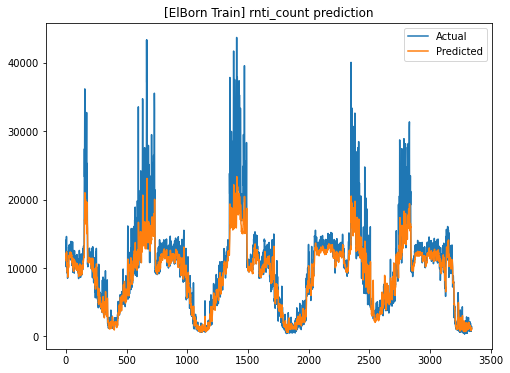

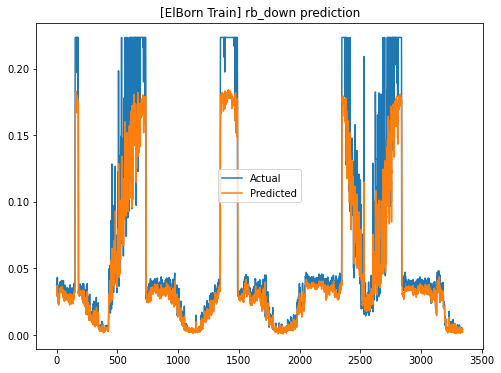

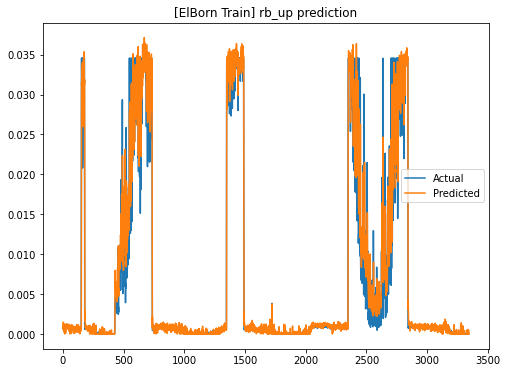

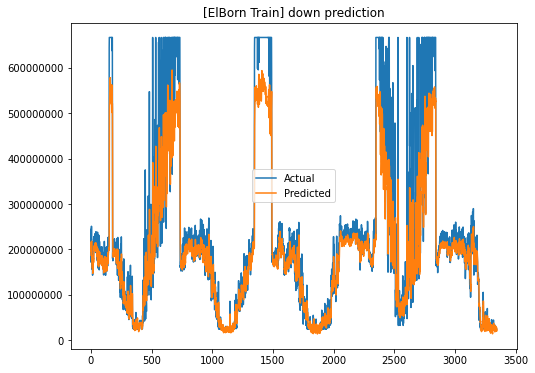

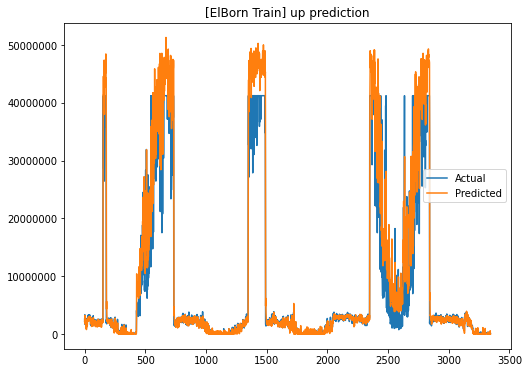

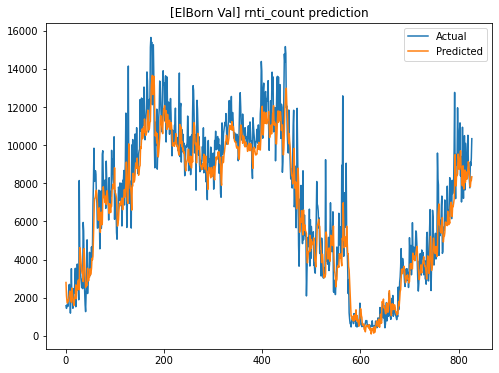

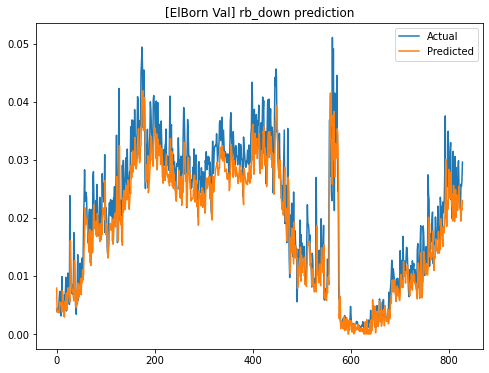

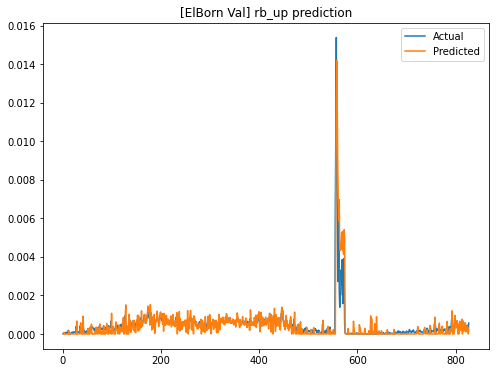

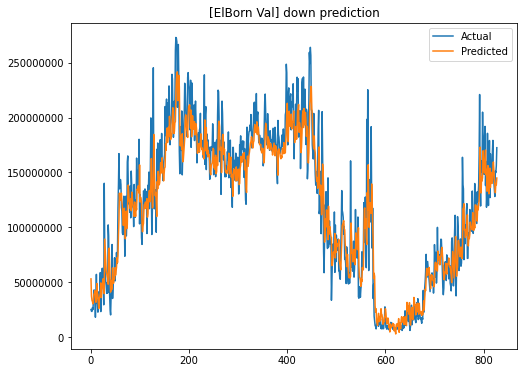

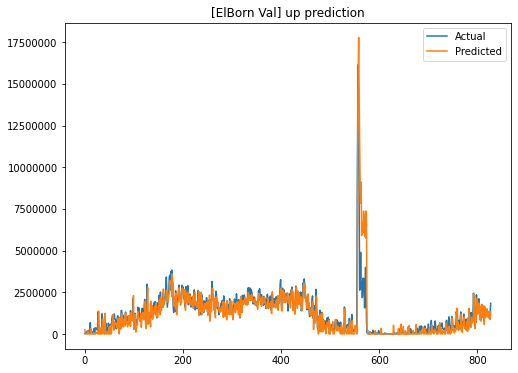

INFO logger 2022-10-25 11:44:56,056 | helpers.py:60 | Metrics for dimension: 0
	mse: 1900573.0, rmse: 1378.6127084863247, mae: 967.4088134765625, r^2: 0.7818270877480424, nrmse: 0.274077487931324
INFO logger 2022-10-25 11:44:56,058 | helpers.py:60 | Metrics for dimension: 1
	mse: 9.842132567428052e-05, rmse: 0.009920752273607104, mae: 0.007226020097732544, r^2: -1.0920412998570055, nrmse: 0.6403409549753507
INFO logger 2022-10-25 11:44:56,060 | helpers.py:60 | Metrics for dimension: 2
	mse: 5.459043222799664e-06, rmse: 0.0023364595487188867, mae: 0.0011451618047431111, r^2: 0.8842370799045499, nrmse: 0.4964340587396255
INFO logger 2022-10-25 11:44:56,063 | helpers.py:60 | Metrics for dimension: 3
	mse: 537855466143744.0, rmse: 23191711.151696935, mae: 17781630.0, r^2: 0.695665972276132, nrmse: 0.3246410671430947
INFO logger 2022-10-25 11:44:56,064 | helpers.py:60 | Metrics for dimension: 4
	mse: 14540739706880.0, rmse: 3813232.1863322197, mae: 2044627.75, r^2: 0.8678479113208657, nrmse


Final Prediction on LesCorts (Inference Stage)
[Train]: mse: 110479552806912.0, rmse: 10510925.402023934, mae 3965438.0, r2: 0.427507350278517, nrmse: 0.4126948861839471
[Val]: mse: 74067717652480.0, rmse: 8606260.375591712, mae 2971069.5, r2: 0.5563452524662805, nrmse: 0.3625101285956619




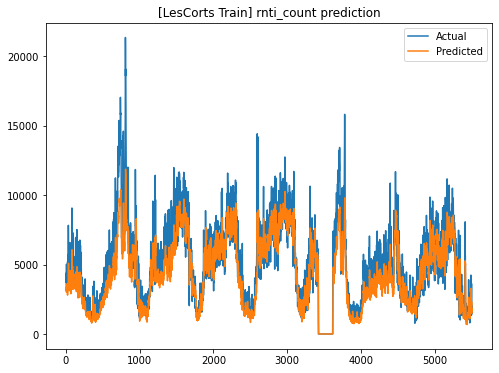

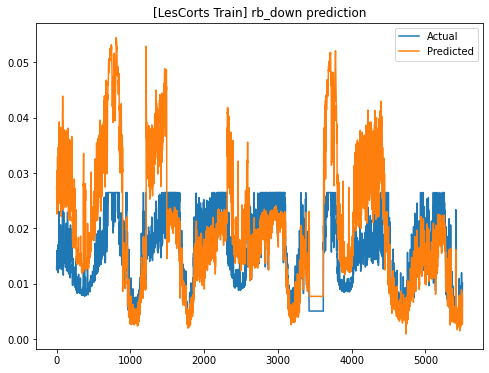

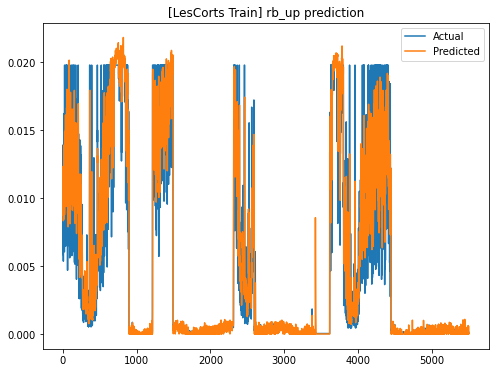

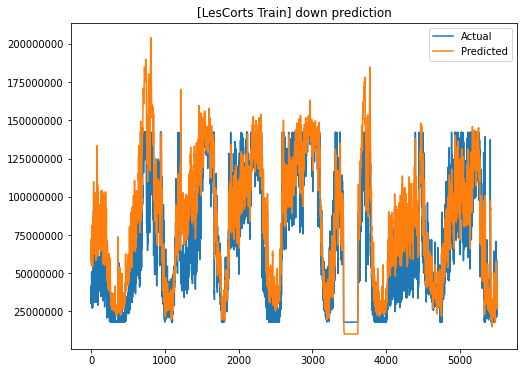

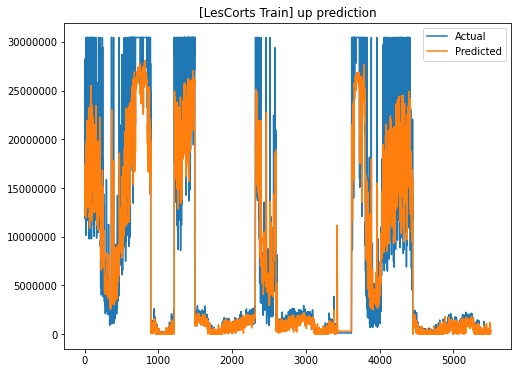

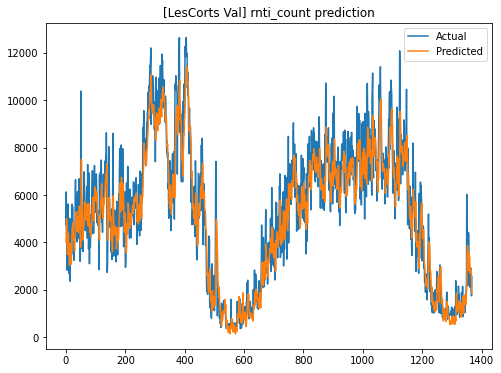

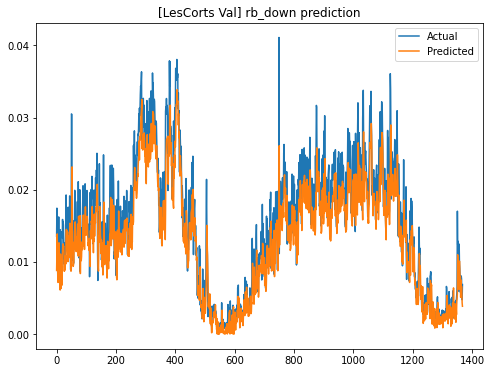

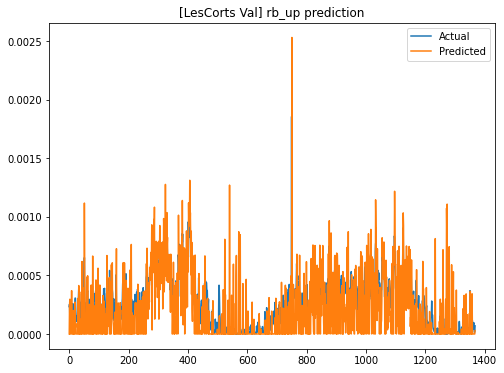

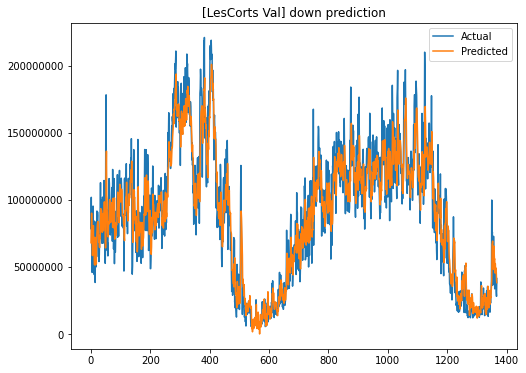

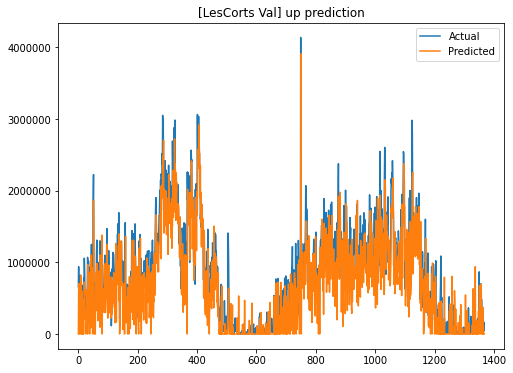

INFO logger 2022-10-25 11:44:57,278 | helpers.py:60 | Metrics for dimension: 0
	mse: 2149756.5, rmse: 1466.2047946995672, mae: 1104.1773681640625, r^2: 0.637667711429948, nrmse: 0.26851178406160325
INFO logger 2022-10-25 11:44:57,280 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0002918097598012537, rmse: 0.017082440100912213, mae: 0.009057426825165749, r^2: 0.824881892354827, nrmse: 0.4936092399463214
INFO logger 2022-10-25 11:44:57,282 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.2805326807429083e-05, rmse: 0.004775492310477432, mae: 0.001894317683763802, r^2: 0.8853719559974036, nrmse: 0.6364859260175525
INFO logger 2022-10-25 11:44:57,284 | helpers.py:60 | Metrics for dimension: 3
	mse: 2218431004803072.0, rmse: 47100222.98039652, mae: 29286086.0, r^2: 0.7707477167986765, nrmse: 0.3673172183614919
INFO logger 2022-10-25 11:44:57,286 | helpers.py:60 | Metrics for dimension: 4
	mse: 38150772621312.0, rmse: 6176631.17089826, mae: 2520571.75, r^2: 0.8793107159476325, nrmse: 


Final Prediction on PobleSec (Inference Stage)
[Train]: mse: 451316572749824.0, rmse: 21244212.68839643, mae 6361550.5, r2: 0.7995959985056975, nrmse: 0.4965499009471995
[Val]: mse: 806895774334976.0, rmse: 28405910.90486232, mae 7605085.0, r2: 0.5485766460025991, nrmse: 1.1304038164549526




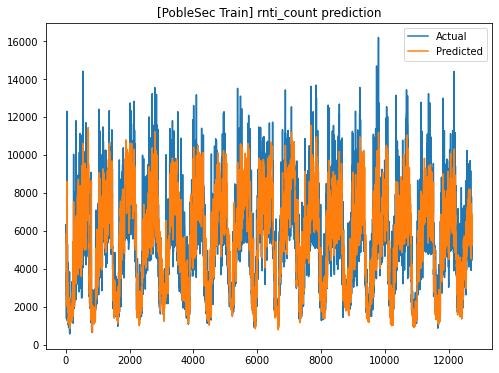

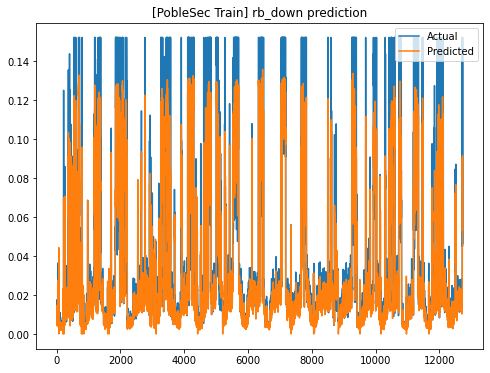

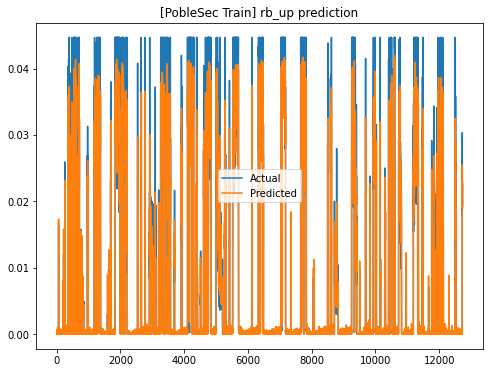

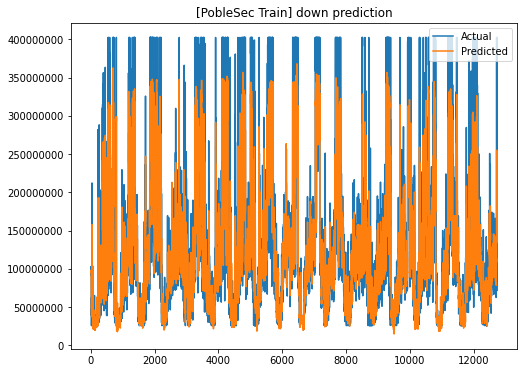

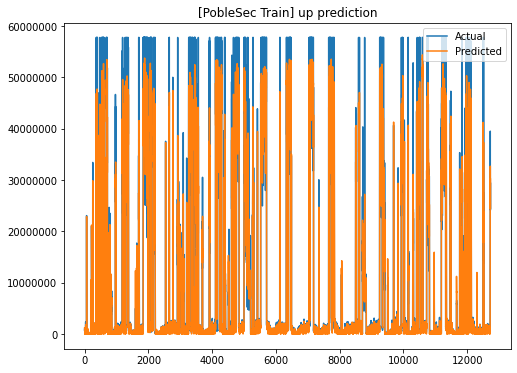

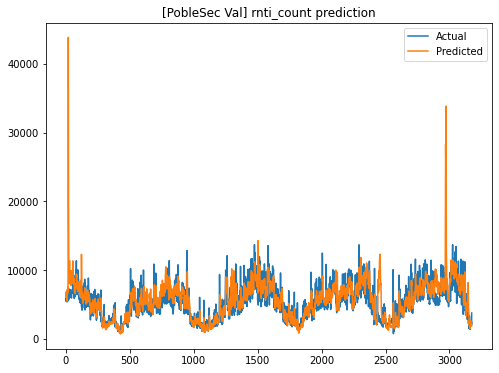

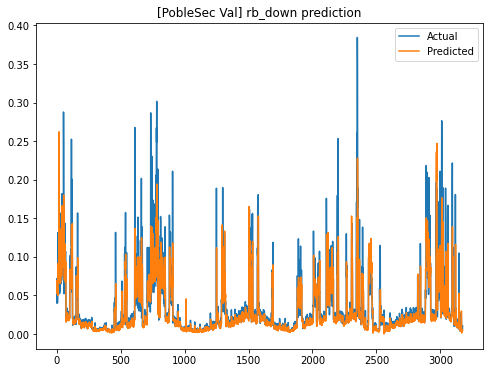

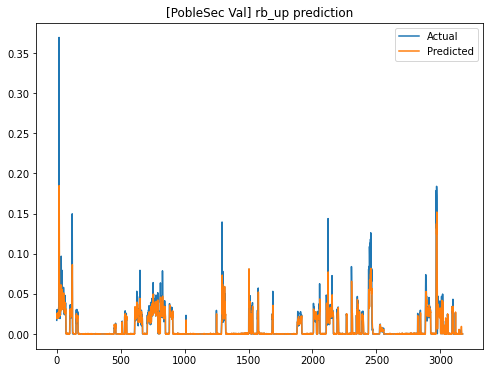

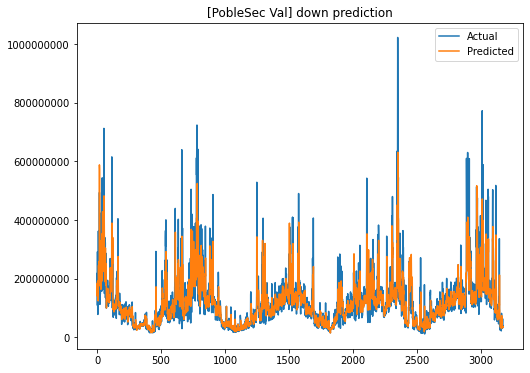

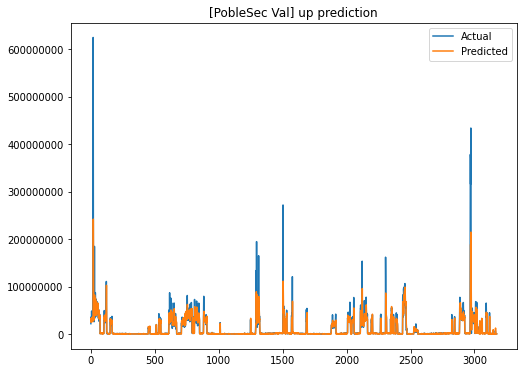

In [28]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scaler
)

### Here we test our trained model on previous unseen test data

In [29]:
def transform_preds_test(y_pred_test):
    if not isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.cpu().numpy()
    return y_pred_test

def round_predictions_test(y_pred_test, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_test
    for dim in dims:
        y_pred_test[:, dim] = np.rint(y_pred_test[:, dim])
    return y_pred_test

def inverse_transform_test(
    y_test, y_pred_test,
    y_scaler=None, 
    round_preds=False,
    dims=None):
    
    y_pred_test = transform_preds_test(y_pred_test)
    
    if y_scaler is not None:
        y_test = y_scaler.inverse_transform(y_test)
        y_pred_test = y_scaler.inverse_transform(y_pred_test)
    
    # to zeroes
    y_pred_test[y_pred_test < 0.] = 0.
    
    if round_preds:
        y_pred_test = round_predictions_test(y_pred_test, dims)
    
    return y_test, y_pred_test

def predict(
            model,
            cid, 
            X_test,
            y_test,
            exogenous_data_test,
            plot,
            idxs=[8, 3, 1, 10, 9],
            apply_round=True,
            round_dimensions=[0, 3, 4]
           ):
    
    if "test" in cid:
        tmp_cid = cid.split("_")
        for s_t in tmp_cid:
            if s_t != "test":
                cid = s_t
                break
    
    num_features = len(X_test[0][0])
    
    test_loader = to_torch_dataset(
        X_test, y_test,
        num_lags=args.num_lags,
        num_features=num_features,
        exogenous_data=exogenous_data_test,
        indices=idxs,
        batch_size=1,
        shuffle=False
    )
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, y_pred_test = test(
                model, test_loader, None, device=device
    )
    
    y_test, y_pred_test = inverse_transform_test(
        y_test, y_pred_test, y_scaler, round_preds=apply_round, dims=round_dimensions
    )
    
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, test_res_per_dim = accumulate_metric(
        y_test, y_pred_test, log_per_output=True, return_all=True
    )
    print(f"Final Prediction in {cid}")
    print(f"[Test]: mse: {test_mse}, rmse: {test_rmse}, mae {test_mae}, "
        f"r2: {test_r2}, nrmse: {test_nrmse}\n\n")
    
    if plot:
        make_plot(y_test, y_pred_test, title="Test", feature_names=args.targets, client=cid)
    

In [30]:
def model_test(
    model, 
    data_paths, 
    x_scaler, 
    y_scaler,
    plot=True,
    idxs=[8, 3, 1, 10, 9],
    round_predictions=False,
    round_dimensions=[0, 3, 4],
):
    # In testing we should pre-process and post-process our data and
    # instruct our model to perform predictions
    
    # read the data
    for client in data_paths:
        df = read_data(client)
    
        if args.identifier not in df.columns:
            cid = os.path.splitext(os.path.basename(client))[0]
            df[args.identifier] = cid
        
        test_data = df.copy()
        
        # get X_test, y_test
        X_test, y_test = to_Xy(test_data, targets=args.targets)
        
        # scale features, targets
        X_test = scale_features(X_test, scaler=x_scaler, per_area=False)
        y_test = scale_features(y_test, scaler=y_scaler, per_area=False)
        
        # generate time lags
        X_test = generate_time_lags(X_test, args.num_lags)
        y_test = generate_time_lags(y_test, args.num_lags, is_y=True)
        
        # get datetime features (if specified)
        date_time_df_test = time_to_feature(
            X_test, args.use_time_features, identifier=args.identifier
        )
        
        # get statistics as features (if specified)
        stats_df_test = assign_statistics(X_test, args.assign_stats, args.num_lags,
                          targets=args.targets, identifier=args.identifier)
    
        if date_time_df_test is not None or stats_df_test is not None:
            exogenous_data_test = pd.concat([date_time_df_test, stats_df_test], axis=1)
            exogenous_data_test = exogenous_data_test.loc[:, ~exogenous_data_test.columns.duplicated()].copy()
        else:
            exogenous_data_test = None
        
        # transform to numpy
        if exogenous_data_test is not None:
            exogenous_data_test = get_exogenous_data_by_area(
                exogenous_data_test, identifier=args.identifier
            )
            
            for cid in exogenous_data_test:
                exogenous_data_test[cid] = exogenous_data_test[cid].to_numpy()
        
        # remove identifiers
        X_test, y_test = remove_identifiers(X_test, y_test)
        
        num_features = len(X_test.columns) // args.num_lags
        
        # to timeseries representation
        X_test = to_timeseries_rep(X_test.to_numpy(), args.num_lags, num_features=num_features)
        
        y_test = y_test.to_numpy()
        
        if exogenous_data_test is not None:
            assert len(exogenous_data_test) == 1
            exogenous_data_test = exogenous_data_test[next(iter(exogenous_data_test))]
            
        # make predictions
        predict(model, cid, X_test, y_test, exogenous_data_test, plot, idxs)

In [31]:
test_data_paths = ["../dataset/LesCorts_test.csv", "../dataset/ElBorn_test.csv", "../dataset/PobleSec_test.csv"]

INFO logger 2022-10-25 11:45:01,737 | helpers.py:60 | Metrics for dimension: 0
	mse: 1389481.375, rmse: 1178.7626457434083, mae: 905.9486083984375, r^2: 0.8102921784845496, nrmse: 0.18290658380133218
INFO logger 2022-10-25 11:45:01,739 | helpers.py:60 | Metrics for dimension: 1
	mse: 1.8600239855004475e-05, rmse: 0.004312799538003648, mae: 0.0033356137573719025, r^2: 0.7179334915306773, nrmse: 0.23207811067694947
INFO logger 2022-10-25 11:45:01,741 | helpers.py:60 | Metrics for dimension: 2
	mse: 5.523965995735125e-08, rmse: 0.00023503118932888725, mae: 0.00018453011580277234, r^2: -0.4526240258412686, nrmse: 0.7091689338154709
INFO logger 2022-10-25 11:45:01,743 | helpers.py:60 | Metrics for dimension: 3
	mse: 412865341161472.0, rmse: 20319088.098668996, mae: 15735653.0, r^2: 0.8148732899978124, nrmse: 0.18645519928944346
INFO logger 2022-10-25 11:45:01,746 | helpers.py:60 | Metrics for dimension: 4
	mse: 208255746048.0, rmse: 456350.4640602439, mae: 348099.9375, r^2: 0.47401044176473

Final Prediction in LesCorts
[Test]: mse: 82614652239872.0, rmse: 9089260.269123776, mae 3216933.0, r2: 0.472897075187302, nrmse: 0.3099656719674115




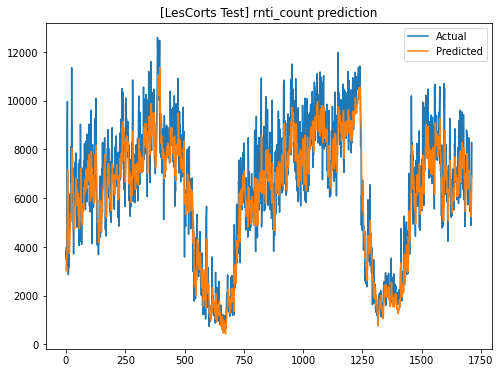

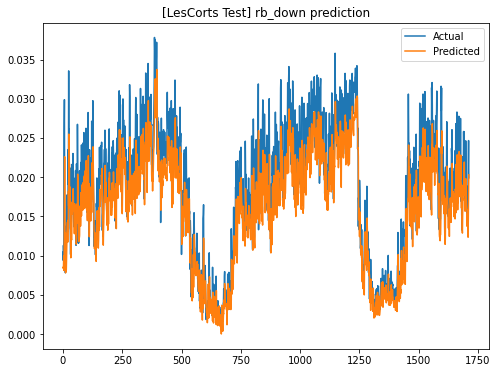

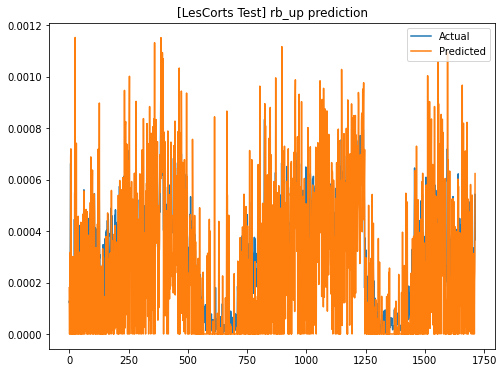

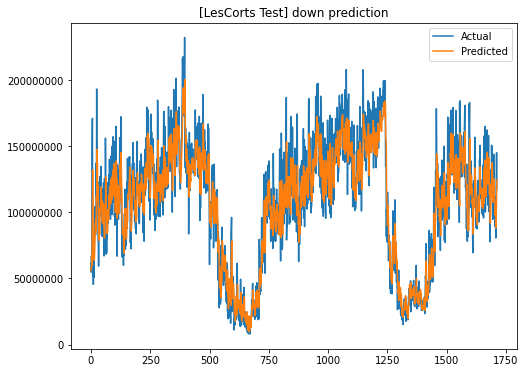

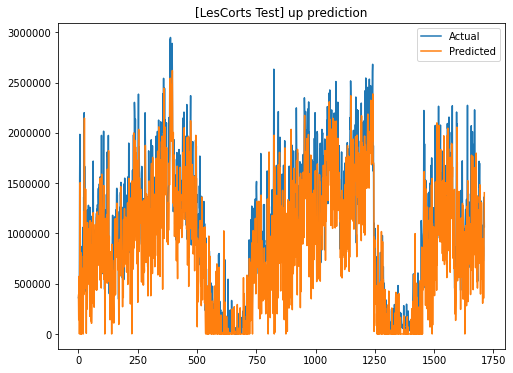

INFO logger 2022-10-25 11:45:03,968 | helpers.py:60 | Metrics for dimension: 0
	mse: 3924772.75, rmse: 1981.1039220596178, mae: 1331.2454833984375, r^2: 0.7375631289384768, nrmse: 0.24072644944182525
INFO logger 2022-10-25 11:45:03,969 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.001184911117888987, rmse: 0.03442253793503592, mae: 0.013491101562976837, r^2: 0.6527943371043892, nrmse: 0.7364274899372287
INFO logger 2022-10-25 11:45:03,970 | helpers.py:60 | Metrics for dimension: 2
	mse: 3.0478187909466214e-05, rmse: 0.005520705381512965, mae: 0.0018234746530652046, r^2: 0.6813928479283984, nrmse: 1.1725398736240387
INFO logger 2022-10-25 11:45:03,972 | helpers.py:60 | Metrics for dimension: 3
	mse: 7730647464411136.0, rmse: 87924100.58915097, mae: 42626820.0, r^2: 0.6504414792987555, nrmse: 0.4725879348227087
INFO logger 2022-10-25 11:45:03,973 | helpers.py:60 | Metrics for dimension: 4
	mse: 68710895190016.0, rmse: 8289203.531704117, mae: 2815484.5, r^2: 0.5724508582765926, nrmse

Final Prediction in ElBorn
[Test]: mse: 1559870650187776.0, rmse: 39495197.81173119, mae 9088726.0, r2: 0.6589285303093225, nrmse: 0.881661425177114




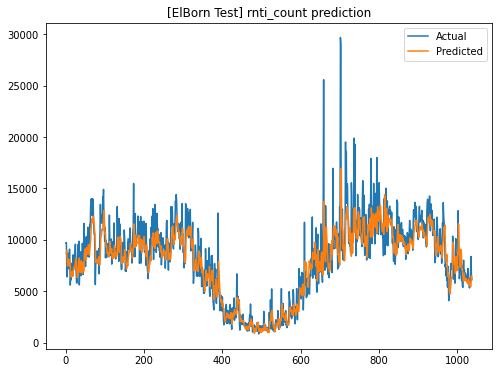

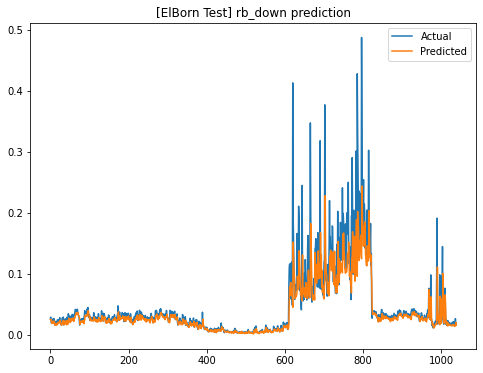

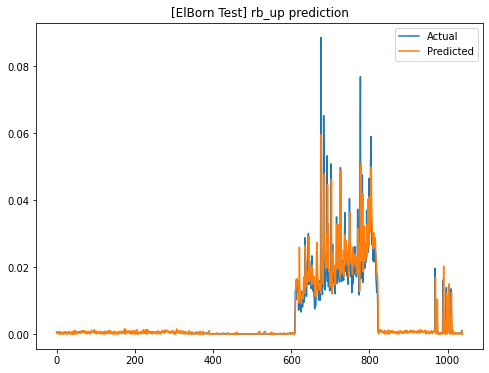

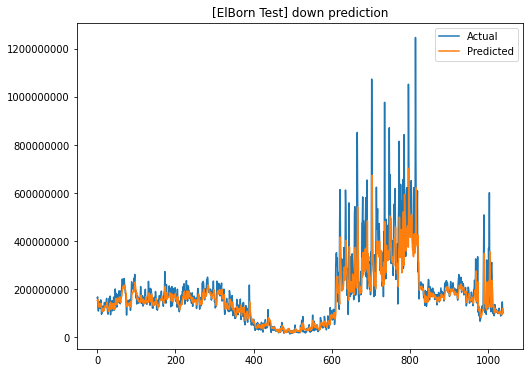

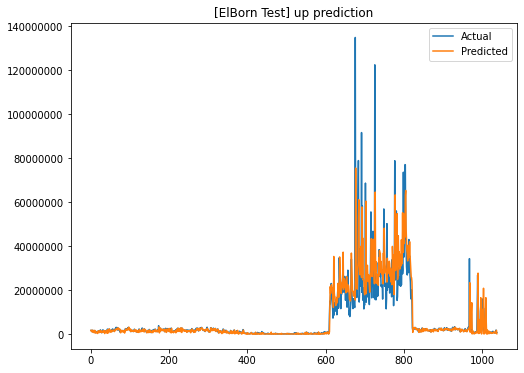

INFO logger 2022-10-25 11:45:09,207 | helpers.py:60 | Metrics for dimension: 0
	mse: 4074035.5, rmse: 2018.424013927698, mae: 1413.9833984375, r^2: 0.41506455051928604, nrmse: 0.34007172905535266
INFO logger 2022-10-25 11:45:09,208 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0013955837348476052, rmse: 0.03735751242852775, mae: 0.01616843231022358, r^2: 0.6485486228737016, nrmse: 0.7692214551973549
INFO logger 2022-10-25 11:45:09,210 | helpers.py:60 | Metrics for dimension: 2
	mse: 0.00012031920778099447, rmse: 0.010969011249013946, mae: 0.003813106333836913, r^2: 0.6865240454998272, nrmse: 1.0462148557721187
INFO logger 2022-10-25 11:45:09,213 | helpers.py:60 | Metrics for dimension: 3
	mse: 6819806770626560.0, rmse: 82582121.37397876, mae: 43755000.0, r^2: 0.641658854131265, nrmse: 0.5138721850258403
INFO logger 2022-10-25 11:45:09,215 | helpers.py:60 | Metrics for dimension: 4
	mse: 251207385874432.0, rmse: 15849523.206533123, mae: 5060093.0, r^2: 0.6121026787164667, nrmse: 1.

Final Prediction in PobleSec
[Test]: mse: 1414203881553920.0, rmse: 37605902.21699142, mae 9763287.0, r2: 0.6007797503481094, nrmse: 0.8391755861915238




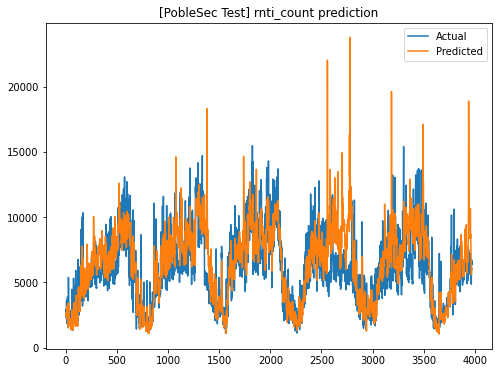

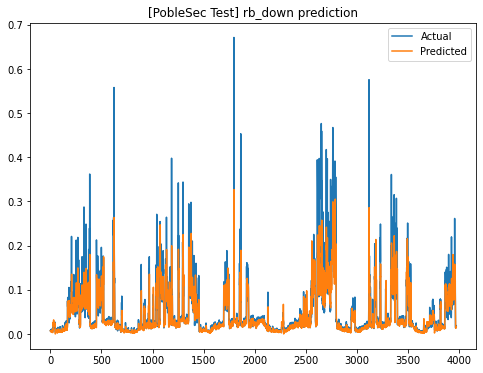

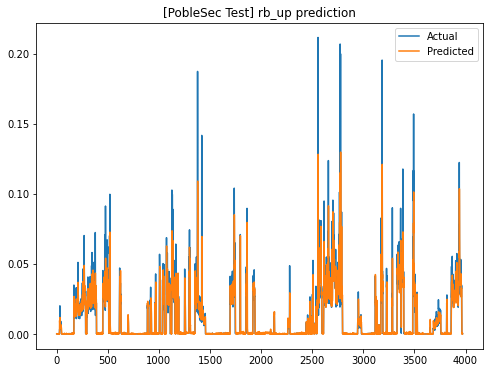

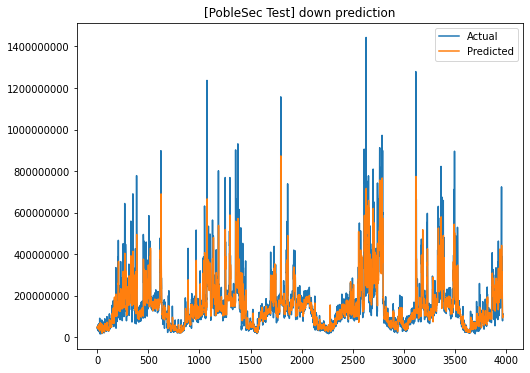

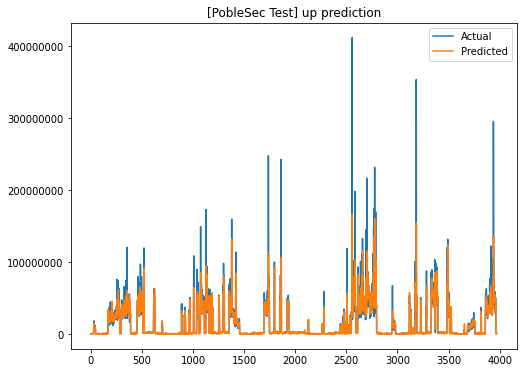

In [32]:
model_test(global_model, 
           test_data_paths, 
           x_scaler, y_scaler,
           round_predictions=True,
          )

In [33]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

In [34]:
def get_minmax_attrs(scaler):
    scaler_attrs = dict()
    scaler_attrs["min_"] = scaler.min_
    scaler_attrs["scale_"] = scaler.scale_
    scaler_attrs["data_min_"] = scaler.data_min_
    scaler_attrs["data_max_"] = scaler.data_max_
    scaler_attrs["data_range_"] = scaler.data_range_
    scaler_attrs["n_features_in_"] = np.array([scaler.n_features_in_])
    scaler_attrs["n_samples_seen_"] = np.array([scaler.n_samples_seen_])
    scaler_attrs["feature_names_in_"] = scaler.feature_names_in_
    
    print(scaler_attrs)
    
    return scaler_attrs

In [35]:
x_scaler_attrs = get_minmax_attrs(x_scaler)
print("\n\n")
y_scaler_attrs = get_minmax_attrs(y_scaler)

{'min_': array([-0.02778567, -0.0008259 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.0189285 ,  0.        , -0.00037316,
        0.        ], dtype=float32), 'scale_': array([1.5418619e-09, 1.7316220e-08, 2.2870212e-05, 6.1176602e-02,
       9.9160559e-03, 3.2258064e-02, 4.1493778e-03, 4.5598941e+00,
       1.0000000e+00, 2.2389420e+01, 1.0000000e+00], dtype=float32), 'data_min_': array([1.8020858e+07, 4.7695199e+04, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.1510835e-03,
       0.0000000e+00, 1.6666667e-05, 0.0000000e+00], dtype=float32), 'data_max_': array([6.6658739e+08, 5.7797020e+07, 4.3725000e+04, 1.6346119e+01,
       1.0084655e+02, 3.1000000e+01, 2.4100000e+02, 2.2345443e-01,
       1.7914095e-07, 4.4680621e-02, 9.3972027e-08], dtype=float32), 'data_range_': array([6.4856653e+08, 5.7749324e+07, 4.3725000e+04, 1.6346119e+01,
       1.0084655e+02, 3.1000000e+01, 2.4100000e+02, 2.1930334e-01,
       1.7914095

#### Store to hdf5 format

In [36]:
import h5py

In [37]:
class ModelSerializer:
    def __init__(self, 
                 model_state, 
                 x_scaler_state,
                 y_scaler_state,
                 save_path: str):
        self.model_state = model_state
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        np_weights = self.state_to_numpy(self.model_state)
        with h5py.File(self.save_path, "w") as f:
            group = f.create_group("model_weights", track_order=True)
            for k, v in np_weights.items():
                group[k] = v
            group = f.create_group("x_scaler", track_order=True)
            for k, v in self.x_scaler.items():
                group[k] = v
            group=f.create_group("y_scaler", track_order=True)
            for k, v in self.y_scaler.items():
                group[k] = v
            

    @staticmethod
    def state_to_numpy(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) == np.ndarray:
            return model_state
        np_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            np_ordered_dict[k] = v.cpu().numpy().astype(np.float64)
        return np_ordered_dict

In [38]:
serializer = ModelSerializer(global_model.state_dict(), x_scaler_attrs, y_scaler_attrs, save_path="model_checkpoint/demo_model.h5")

In [39]:
serializer.save()

#### Load back

In [40]:
class ModelLoader:
    def __init__(self, model_path: str, 
                 to_torch: bool = True):
        self.model_path = model_path
        self.to_torch = to_torch

    def load(self):
        state_dict = OrderedDict()
        x_scaler, y_scaler = OrderedDict(), OrderedDict()
        with h5py.File(self.model_path, "r") as f:
            keys = list(f.keys())
            assert "model_weights" in keys
            assert "x_scaler" in keys
            assert "y_scaler" in keys
            model_weights = f["model_weights"]
            named_params = model_weights.keys()
            for k in named_params:
                state_dict[k] = model_weights[k][:]
                
            x_scaler_state = f["x_scaler"]
            named_params = x_scaler_state.keys()
            for k in named_params:
                print(k)
                x_scaler[k] = x_scaler_state[k][:]
            
            y_scaler_state = f["y_scaler"]
            named_params = y_scaler_state.keys()
            for k in named_params:
                y_scaler[k] = y_scaler_state[k][:]
            
        if self.to_torch:
            state_dict = self.state_to_torch(state_dict)
        return state_dict, x_scaler, y_scaler

    @staticmethod
    def state_to_torch(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) in (torch.tensor, torch.Tensor):
            return model_state
        torch_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            torch_ordered_dict[k] = torch.tensor(v).float()
        return torch_ordered_dict

In [41]:
model_loader = ModelLoader("model_checkpoint/demo_model.h5")
state_dict, x_scaler, y_scaler = model_loader.load()

min_
scale_
data_min_
data_max_
data_range_
n_features_in_
n_samples_seen_
feature_names_in_


In [42]:
state_dict[next(iter(state_dict))]

tensor([[-0.0007,  0.1144, -0.0728,  ..., -0.0855,  0.0670, -0.0923],
        [-0.0174, -0.0257, -0.0585,  ...,  0.0192,  0.0769,  0.0974],
        [-0.0182,  0.0923, -0.0142,  ..., -0.0156,  0.1065,  0.0032],
        ...,
        [ 0.0565,  0.0359, -0.0639,  ...,  0.1369,  0.1114, -0.0334],
        [-0.0839, -0.0333, -0.0485,  ..., -0.0153,  0.0536, -0.0537],
        [ 0.0337,  0.0683, -0.0743,  ..., -0.0002,  0.0649,  0.1077]])

In [43]:
x_scaler

OrderedDict([('min_',
              array([-0.02778567, -0.0008259 ,  0.        ,  0.        ,  0.        ,
                      0.        ,  0.        , -0.0189285 ,  0.        , -0.00037316,
                      0.        ], dtype=float32)),
             ('scale_',
              array([1.5418619e-09, 1.7316220e-08, 2.2870212e-05, 6.1176602e-02,
                     9.9160559e-03, 3.2258064e-02, 4.1493778e-03, 4.5598941e+00,
                     1.0000000e+00, 2.2389420e+01, 1.0000000e+00], dtype=float32)),
             ('data_min_',
              array([1.8020858e+07, 4.7695199e+04, 0.0000000e+00, 0.0000000e+00,
                     0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.1510835e-03,
                     0.0000000e+00, 1.6666667e-05, 0.0000000e+00], dtype=float32)),
             ('data_max_',
              array([6.6658739e+08, 5.7797020e+07, 4.3725000e+04, 1.6346119e+01,
                     1.0084655e+02, 3.1000000e+01, 2.4100000e+02, 2.2345443e-01,
                     1

In [44]:
y_scaler

OrderedDict([('min_',
              array([ 0.        , -0.0189285 , -0.00037316, -0.02778567, -0.0008259 ],
                    dtype=float32)),
             ('scale_',
              array([2.2870212e-05, 4.5598941e+00, 2.2389420e+01, 1.5418619e-09,
                     1.7316220e-08], dtype=float32)),
             ('data_min_',
              array([0.0000000e+00, 4.1510835e-03, 1.6666667e-05, 1.8020858e+07,
                     4.7695199e+04], dtype=float32)),
             ('data_max_',
              array([4.3725000e+04, 2.2345443e-01, 4.4680621e-02, 6.6658739e+08,
                     5.7797020e+07], dtype=float32)),
             ('data_range_',
              array([4.3725000e+04, 2.1930334e-01, 4.4663955e-02, 6.4856653e+08,
                     5.7749324e+07], dtype=float32)),
             ('n_features_in_', array([5])),
             ('n_samples_seen_', array([21610])),
             ('feature_names_in_',
              array([b'rnti_count', b'rb_down', b'rb_up', b'down', b'up'], dt

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
def set_minmax_attrs(scaler, scaler_attrs):
    scaler.min_ = scaler_attrs["min_"]
    scaler.scale_ = scaler_attrs["scale_"]
    scaler.data_min_ = scaler_attrs["data_min_"]
    scaler.data_max_ = scaler_attrs["data_max_"]
    scaler.data_range_ = scaler_attrs["data_range_"]
    scaler.n_features_in_ = scaler_attrs["n_features_in_"][0] 
    scaler.n_samples_seen_ = scaler_attrs["n_samples_seen_"][0]
    scaler.feature_names_in_ = scaler_attrs["feature_names_in_"] 
    
    return scaler

In [47]:
tmp_scaler = MinMaxScaler()

In [48]:
tmp_scaler = set_minmax_attrs(tmp_scaler, y_scaler)

In [49]:
tmp_scaler

MinMaxScaler()

In [50]:
tmp_scaler.inverse_transform(np.array(
    [[1., 1., 1., 1., 1.],
    [0.5, 0.5, 0.5, 0.5, 0.5]]
))

array([[4.37249992e+04, 2.23454423e-01, 4.46806204e-02, 6.66587390e+08,
        5.77970207e+07],
       [2.18624996e+04, 1.13802753e-01, 2.23486436e-02, 3.42304124e+08,
        2.89223579e+07]])